In [1]:
import logging
from utility import add_project_root_to_path

logging.basicConfig(level=logging.ERROR)

add_project_root_to_path()

In [2]:
# Building experiments configs

from experiments.configs import DATA_SOURCE_BY_ALIAS, DEFAULT_UNINFORMED_USERS_CONFIG
from experiments.experiment import Experiment
from user.informed_user import InformedUser

from fee_algorithm.fixed_fee import FixedFee
from fee_algorithm.discrete_fee_perfect_oracle import DiscreteFeePerfectOracle
from fee_algorithm.continuous_fee_perfect_oracle import ContinuousFeePerfectOracle
from fee_algorithm.fee_based_on_historical_price import FeeBasedOnHistoricalPrice

from copy import deepcopy

fee_algos_to_consider = {
    "fixed_fee": FixedFee(exchange_fee_rate=0.003), # 30 bps
    "discrete_fee_perfect_oracle": DiscreteFeePerfectOracle(fee_rate_in_arbitrage_direction=0.0045, fee_rate_in_non_arbitrage_direction=0.0015), # 45/15 bps
    "continuous_fee_perfect_oracle": ContinuousFeePerfectOracle(default_fee_rate=0.003), # 30 bps
    "fee_based_on_historical_price": FeeBasedOnHistoricalPrice(decay=0.3, fee_in_increasing_deviation_direction=0.0045, fee_in_decreasing_deviation_direction=0.0015), # 45/15 bps
}

experiment_configs = {}

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    data_source = DATA_SOURCE_BY_ALIAS[period_alias]
    for fee_algo_alias, fee_algo in fee_algos_to_consider.items():
        experiment_name = f"{period_alias}_{fee_algo_alias}"
        experiment_configs[experiment_name] = Experiment(
            data=data_source,
            fee_algorithm=deepcopy(fee_algo),
            uninformed_users=deepcopy(DEFAULT_UNINFORMED_USERS_CONFIG),
            informed_user=InformedUser(),
        )

In [3]:
from pprint import pprint

pprint(experiment_configs['volatile_market_fixed_fee'])

Experiment(data=ExperimentData(start_time=datetime.datetime(2022, 11, 10, 12, 0),
                               end_time=datetime.datetime(2022, 11, 16, 12, 0),
                               A_symbol='ETH',
                               B_symbol='BTC',
                               stable_coin_symbol='USDT',
                               candle_interval='5m'),
           fee_algorithm=FixedFee(exchange_fee_rate=0.003),
           informed_user=<user.informed_user.InformedUser object at 0x10738da00>,
           uninformed_users=UninformedUsersConfig(uninformed_user=<user.uninformed_user.UninformedUser object at 0x126d5a780>,
                                                  probability_of_trade=0.5,
                                                  n_users=1),
           total_tokens=100000,
           network_fee=5)


In [4]:
pprint(experiment_configs['volatile_market_fixed_fee'])

Experiment(data=ExperimentData(start_time=datetime.datetime(2022, 11, 10, 12, 0),
                               end_time=datetime.datetime(2022, 11, 16, 12, 0),
                               A_symbol='ETH',
                               B_symbol='BTC',
                               stable_coin_symbol='USDT',
                               candle_interval='5m'),
           fee_algorithm=FixedFee(exchange_fee_rate=0.003),
           informed_user=<user.informed_user.InformedUser object at 0x10738da00>,
           uninformed_users=UninformedUsersConfig(uninformed_user=<user.uninformed_user.UninformedUser object at 0x126d5a780>,
                                                  probability_of_trade=0.5,
                                                  n_users=1),
           total_tokens=100000,
           network_fee=5)


In [5]:
from experiments.run_experiment import run_experiment
from experiments.experiment import ExperimentResult
import numpy as np

experiment_results: dict[str, ExperimentResult] = {}


for experiment_name, experiment_config in experiment_configs.items():
    np.random.seed(0)
    experiment_results[experiment_name] = run_experiment(experiment_config)

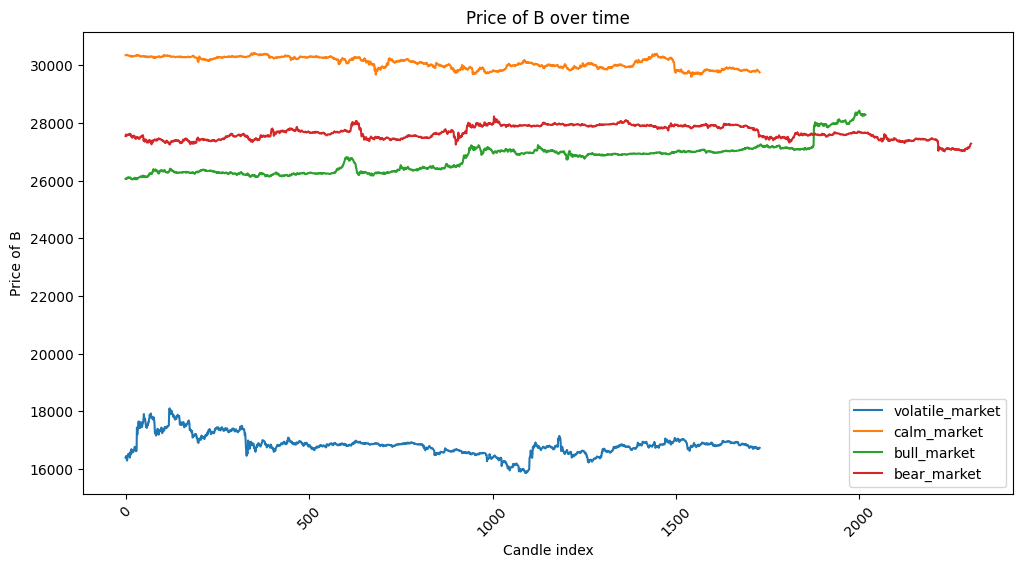

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for period_alias in DATA_SOURCE_BY_ALIAS.keys():
    experiment_name = f"{period_alias}_fixed_fee"
    experiment_result = experiment_results[experiment_name]
    plt.plot(experiment_result.data["price_B"], label=period_alias)
    plt.title("Price of B over time")

plt.ylabel("Price of B")
plt.xlabel("Candle index")
# plt.yscale("log")

plt.xticks(rotation=45)

plt.legend(loc="lower right")

plt.show()

### Results

In [7]:
from visualizations.compare_fee_algoritms import plot_participants_markouts, plot_impermanent_loss, get_experiment_summary

In [8]:
def plot_results_for_period(period_alias: str, fee_algos_to_consider: list[str]):
    plot_participants_markouts(
        period_alias,
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )
    plot_impermanent_loss(
        period_alias,
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )

    summary = get_experiment_summary(
        {
            f"{fee_algo_alias}": experiment_results[f"{period_alias}_{fee_algo_alias}"]
            for fee_algo_alias in fee_algos_to_consider
        }
    )

    display(summary)

### Results for bull market

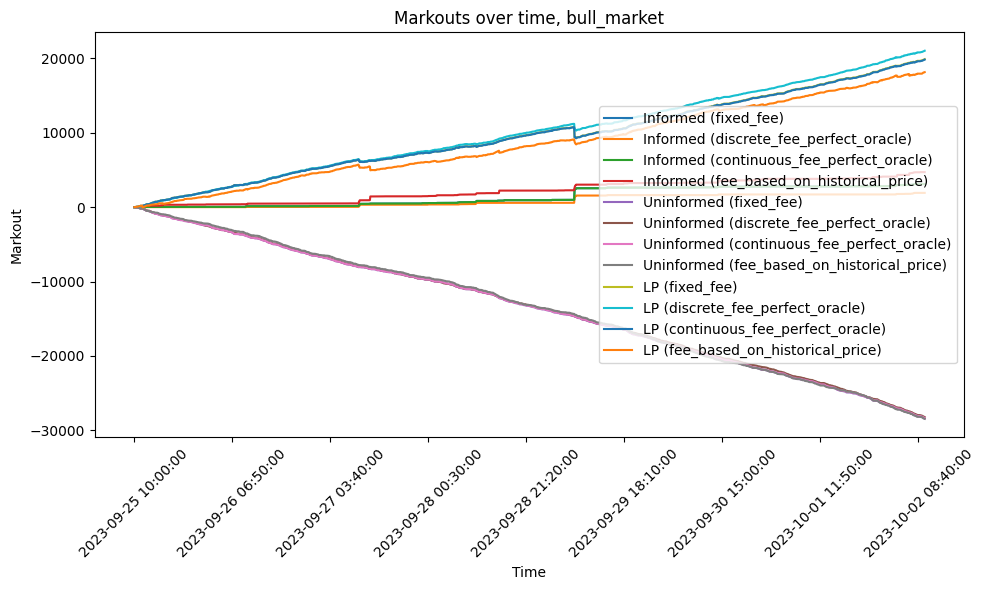

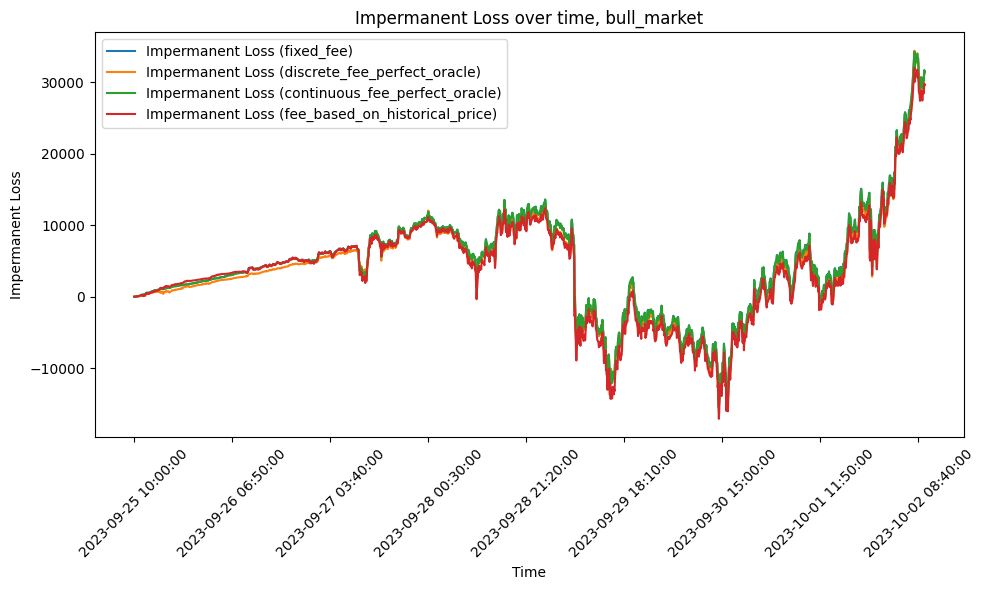

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,3111.051565,-28409.603177,19878.551612,31478.038405
1,discrete_fee_perfect_oracle,1911.919492,-28213.424969,21011.505477,31232.155324
2,continuous_fee_perfect_oracle,3100.658833,-28339.846453,19819.187619,31415.398813
3,fee_based_on_historical_price,4704.026756,-28444.019508,18134.992752,29587.047961


In [9]:
plot_results_for_period("bull_market", list(fee_algos_to_consider.keys()))

### Results for calm market

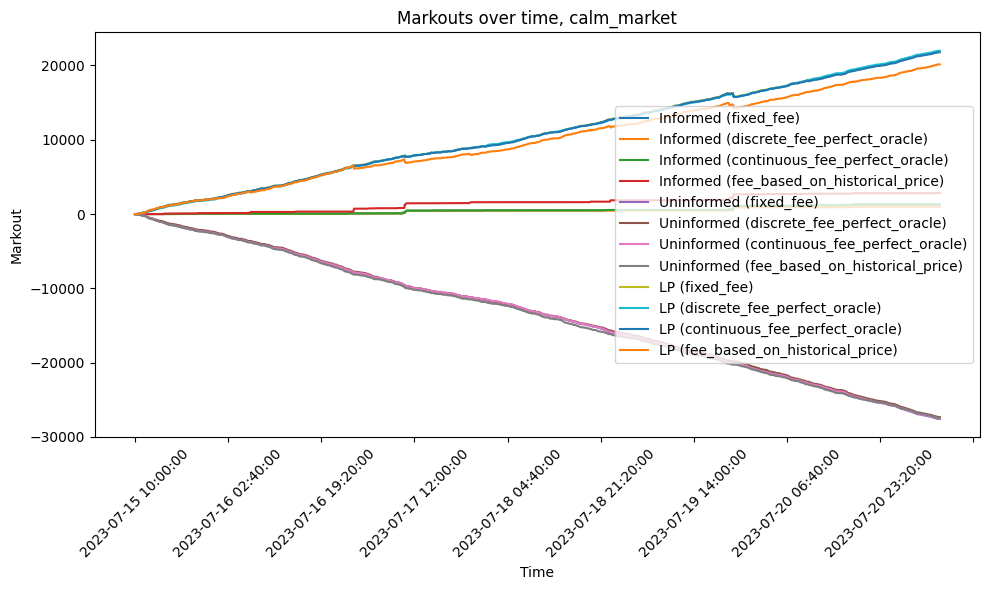

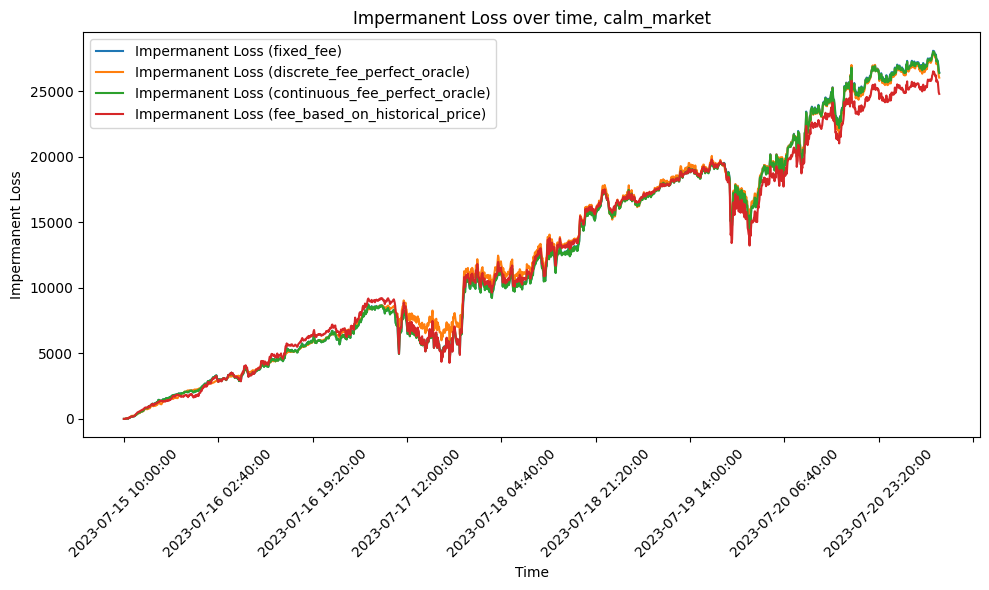

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,1293.385159,-27567.176580,21843.791422,26475.020899
1,discrete_fee_perfect_oracle,990.609052,-27322.501596,21981.892544,26058.394527
2,continuous_fee_perfect_oracle,1288.980380,-27497.500189,21778.519809,26410.568307
3,fee_based_on_historical_price,2820.791380,-27471.160900,20145.369520,24816.343741


In [10]:
plot_results_for_period("calm_market", list(fee_algos_to_consider.keys()))

### Results for bear market

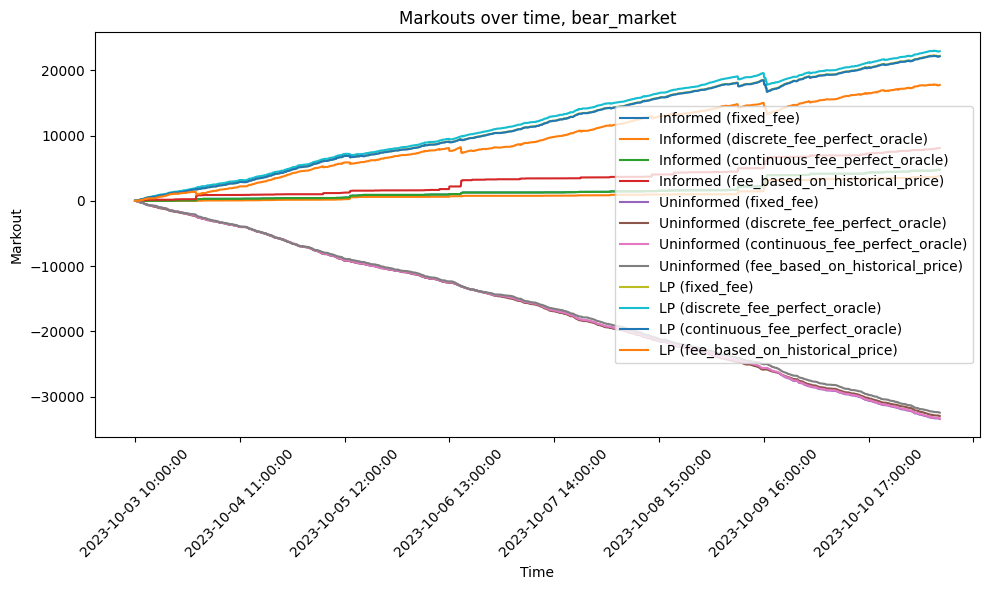

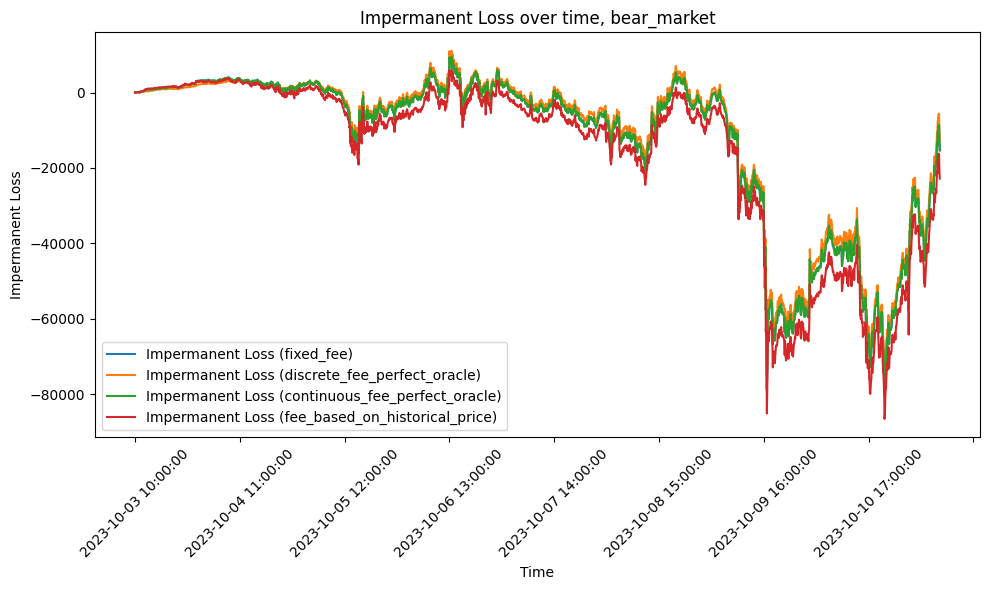

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,4774.547371,-33416.127998,22216.580628,-15310.374463
1,discrete_fee_perfect_oracle,3771.106556,-32973.724751,22937.618194,-12682.716487
2,continuous_fee_perfect_oracle,4758.291135,-33333.582227,22150.291092,-15375.411207
3,fee_based_on_historical_price,8087.269427,-32458.707383,17756.437956,-22821.692543


In [11]:
plot_results_for_period("bear_market", list(fee_algos_to_consider.keys()))

### Results for volatile market

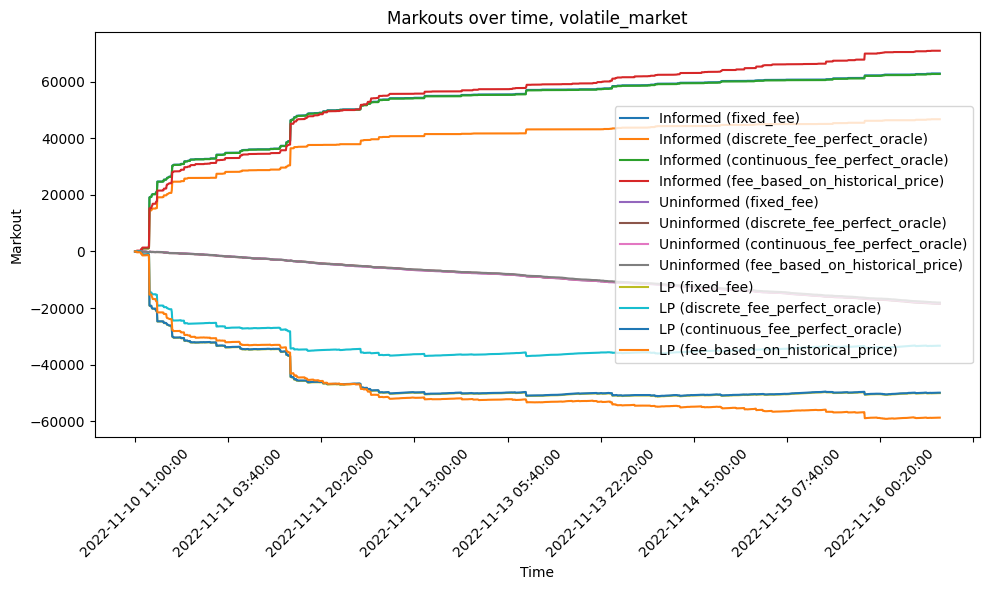

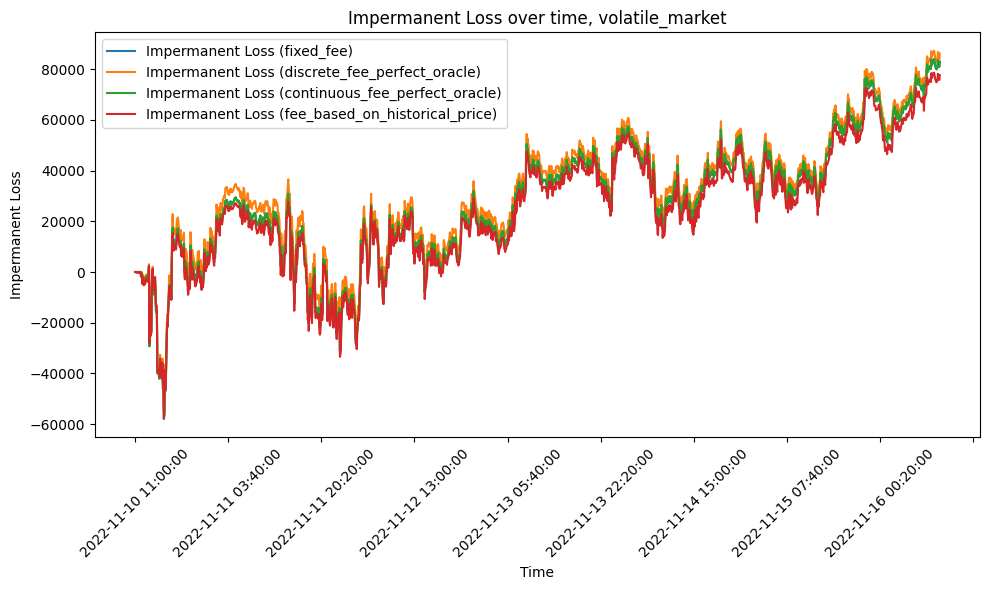

,experiment_name,informed_user_markout,uninformed_user_markout,lp_markout,impermanent_loss
0,fixed_fee,62912.443037,-18390.653397,-50051.789640,82931.016036
1,discrete_fee_perfect_oracle,46737.043455,-18522.004182,-33305.039273,86214.493931
2,continuous_fee_perfect_oracle,62719.918082,-18348.472752,-49901.445330,83076.857866
3,fee_based_on_historical_price,70941.780849,-18055.443081,-58726.337769,77679.766047


In [12]:
plot_results_for_period("volatile_market", list(fee_algos_to_consider.keys()))